In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
from glob import glob

In [2]:
SEED = 0

In [51]:
dataset_names = {
    "german" : "German Credit",
    "compas" : "COMPAS",
    "adult" : "Adult",
}
methods_color = {
    "LGBMClassifier" : "#ffd92f",
    "FairGBMClassifier" : "#fc8d62",
    "MinMaxFair" : "#a6d854",
    "M2FGB_grad" : "#8da0cb",
    #"M2FGB" : "#66c2a5",
    "MinimaxPareto" : "pink"
}
methods_names = {
    "LGBMClassifier" : "LGBM",
    "FairGBMClassifier" : "FairGBM",
    "M2FGB_grad" : "M²FGB",
    #"M2FGB" : "M²FGB opt.",
    "MinMaxFair" : "MinMaxFair",
    "MinimaxPareto" : "MMPF"
}

In [62]:
def summary_experiment(dataset_name, model_name, path, fair_metric = "min_bal_acc", max_models = None):
    results = []

    n_folds = len(glob(path + "validation_fold_*.csv"))
    print(n_folds)
    # For each fold
    for i in range(n_folds):
        results_val = pd.read_csv(path + f"validation_fold_{i}.csv")

        # sample models if there is a limit of max_models
        if i == 0: 
            model_list = results_val.model.unique()
            if max_models is not None and len(model_list) > max_models:
                model_list = np.random.choice(model_list, size = max_models, replace = False)
        if max_models is not None:
            results_val = results_val[results_val.model.isin(model_list)]

        # adjust fairness metric to be better when closer to 1
        if fair_metric in ["eod", "spd"]:
            results_val[fair_metric] = 1 - np.abs(results_val[fair_metric])
        results_val["score"] = results_val["alpha"] * results_val["bal_acc"] + (1 - results_val["alpha"]) * (results_val[fair_metric])


        # identify best model for each alpha based on score
        results_val = results_val.groupby("alpha").apply(lambda x: x.sort_values("score", ascending=False).head(1), include_groups = False).reset_index()
        alpha_list = results_val.alpha.tolist()
        best_models = results_val.model.tolist()


        # select the same models for the test set
        results_test = pd.read_csv(path + f"test_fold_{i}.csv")
        if fair_metric in ["eod", "spd"]:
            results_test[fair_metric] = 1 - np.abs(results_test[fair_metric])
        
        trials = pd.read_csv(path + f"trials_fold_{i}.csv")
        trials["duration"] = pd.to_timedelta(trials["duration"]).dt.total_seconds()

        for alpha, m in zip(alpha_list, best_models):
            best_model = results_test[((results_test.alpha == alpha) & (results_test.model == m))]
            results.append({
                "fold" : i,
                "alpha" : alpha,
                "bal_acc" : best_model.bal_acc.values[0],
                fair_metric : best_model[fair_metric].values[0],
                "dataset" : dataset_name,
                "model" : model_name,
                "time" : trials.duration.values[m],
            })

    results = pd.DataFrame(results).groupby("alpha").agg({
        "dataset" : "first",
        "model" : "first",
        "bal_acc" : "mean",
        fair_metric : "mean",
        "time" : "mean"
    }).reset_index()
    return results

In [63]:
def summary_alpha(alpha, dataset_name, model_name, path, fair_metric = "min_bal_acc", max_models = None):
    results = summary_experiment(dataset_name, model_name, path, fair_metric, max_models)
    results = results[results.alpha == alpha]
    return results

10
10
10


,alpha,dataset,model,bal_acc,min_bal_acc,time
10,0.5,acsincome,M2FGB_grad,0.764208,0.727528,188.913172
10,0.5,acsincome,FairGBMClassifier,0.737758,0.718631,77.717208
10,0.5,acsincome,LGBMClassifier,0.764890,0.707227,22.624612


In [55]:
handles = [
    Line2D([0], [0], marker = "o", color = "w", label=value, markerfacecolor=methods_color[key], markersize=10) for key, value in methods_names.items()
]

10
10
10
10
10
10
10
10
10
10
10
10
10
10
10


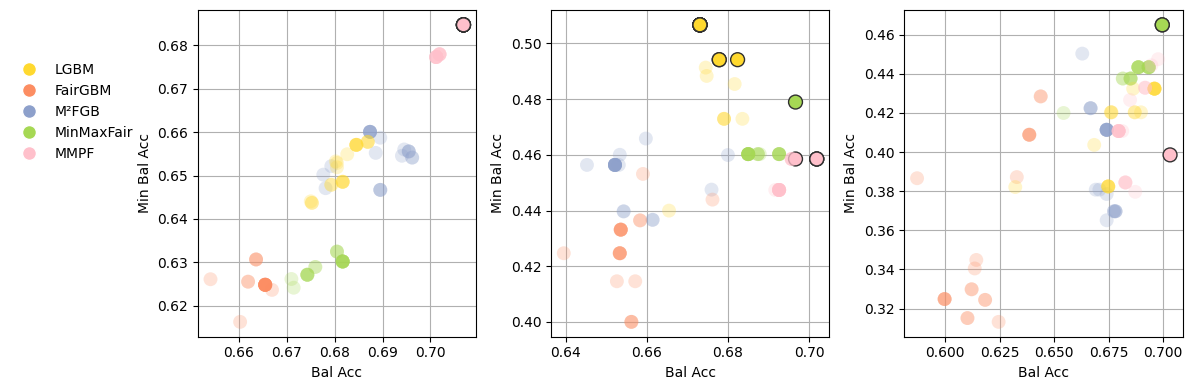

In [56]:
fig, axs = plt.subplots(nrows = 1, ncols = 3, figsize = (12, 4))


dataset_name = "german"
methods = [
    "M2FGB_grad",
    #"M2FGB",
    "FairGBMClassifier",
    "MinMaxFair",
    "LGBMClassifier",
    "MinimaxPareto"
]
for ii, n_groups in enumerate([2, 4, 8]):
    results = []
    for model_name in methods:
        path = f"../results/experiment_{n_groups}_groups/{dataset_name}/{model_name}/"
        results.append(summary_experiment(dataset_name, model_name, path))

    results = pd.concat(results)

    dominated = []
    for i, row in results.iterrows():
        is_dominated = False
        for j, row2 in results.iterrows():
            if i == j:
                continue
            if row["bal_acc"] < row2["bal_acc"] and row["min_bal_acc"] < row2["min_bal_acc"]:
                is_dominated = True
                break
        dominated.append(is_dominated)
    results["dominated"] = dominated


    for model_name in methods:
        results_m = results[results.model == model_name]

        axs[ii].scatter(
            results_m.bal_acc,
            results_m.min_bal_acc,
            c = methods_color[model_name],
            s = 100,
            alpha = [0.25 if d else 1 for d in results_m.dominated],
            label = model_name,
            lw = [0 if d else 1 for d in results_m.dominated],
            zorder = 10,
            ec = ["#ffffff" if d else "#303030" for d in results_m.dominated]
        )

    
    #axs[ii].legend()
    axs[ii].set_xlabel("Bal Acc")
    axs[ii].set_ylabel("Min Bal Acc")
    axs[ii].grid(True)
    if ii == 0:
        axs[ii].legend(handles=handles, loc="lower left", bbox_to_anchor=(-0.7, 0.5), frameon=False)

plt.tight_layout()
plt.show()


In [65]:
dataset_name = "german"
methods = [
    "M2FGB_grad",
    #"M2FGB",
    "FairGBMClassifier",
    "MinMaxFair",
    "LGBMClassifier",
    "MinimaxPareto"
]
n_groups = 8
results = []
for model_name in methods:
    path = f"../results/experiment_{n_groups}_groups/{dataset_name}/{model_name}/"
    results.append(summary_alpha(0.5, dataset_name, model_name, path))
results = pd.concat(results)
results

10
10
10
10
10


,alpha,dataset,model,bal_acc,min_bal_acc,time
10,0.5,german,M2FGB_grad,0.666667,0.422458,2.423148
10,0.5,german,FairGBMClassifier,0.618333,0.324416,0.158722
10,0.5,german,MinMaxFair,0.688571,0.443416,41.089950
10,0.5,german,LGBMClassifier,0.695952,0.432436,0.371569
10,0.5,german,MinimaxPareto,0.679524,0.410767,21.480954


10
10
10
10
10
10
10
10
10
10
10
10
10
10
10


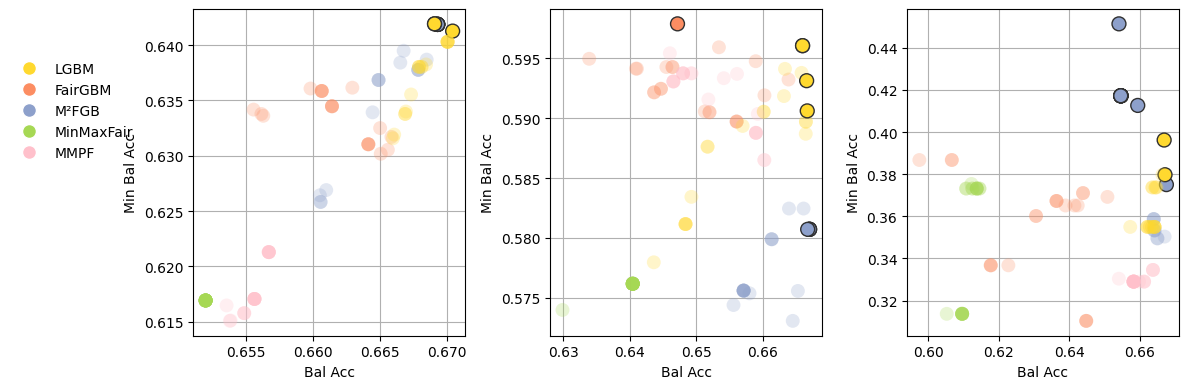

In [57]:
fig, axs = plt.subplots(nrows = 1, ncols = 3, figsize = (12, 4))


dataset_name = "compas"
methods = [
    "M2FGB_grad",
    #"M2FGB",
    "FairGBMClassifier",
    "MinMaxFair",
    "LGBMClassifier",
    "MinimaxPareto"
]
for ii, n_groups in enumerate([2, 4, 8]):
    results = []
    for model_name in methods:
        path = f"../results/experiment_{n_groups}_groups/{dataset_name}/{model_name}/"
        results.append(summary_experiment(dataset_name, model_name, path))

    results = pd.concat(results)

    dominated = []
    for i, row in results.iterrows():
        is_dominated = False
        for j, row2 in results.iterrows():
            if i == j:
                continue
            if row["bal_acc"] < row2["bal_acc"] and row["min_bal_acc"] < row2["min_bal_acc"]:
                is_dominated = True
                break
        dominated.append(is_dominated)
    results["dominated"] = dominated


    for model_name in methods:
        results_m = results[results.model == model_name]

        axs[ii].scatter(
            results_m.bal_acc,
            results_m.min_bal_acc,
            c = methods_color[model_name],
            s = 100,
            alpha = [0.25 if d else 1 for d in results_m.dominated],
            label = model_name,
            lw = [0 if d else 1 for d in results_m.dominated],
            zorder = 10,
            ec = ["#ffffff" if d else "#303030" for d in results_m.dominated]
        )

    
    #axs[ii].legend()
    axs[ii].set_xlabel("Bal Acc")
    axs[ii].set_ylabel("Min Bal Acc")
    axs[ii].grid(True)
    if ii == 0:
        axs[ii].legend(handles=handles, loc="lower left", bbox_to_anchor=(-0.7, 0.5), frameon=False)

plt.tight_layout()
plt.show()


In [66]:
dataset_name = "compas"
methods = [
    "M2FGB_grad",
    #"M2FGB",
    "FairGBMClassifier",
    "MinMaxFair",
    "LGBMClassifier",
    "MinimaxPareto"
]
n_groups = 8
results = []
for model_name in methods:
    path = f"../results/experiment_{n_groups}_groups/{dataset_name}/{model_name}/"
    results.append(summary_alpha(0.5, dataset_name, model_name, path))
results = pd.concat(results)
results

10
10
10
10
10


,alpha,dataset,model,bal_acc,min_bal_acc,time
10,0.5,compas,M2FGB_grad,0.659390,0.412643,6.560080
10,0.5,compas,FairGBMClassifier,0.636341,0.367283,0.381420
10,0.5,compas,MinMaxFair,0.613709,0.373180,53.974838
10,0.5,compas,LGBMClassifier,0.664159,0.354963,0.198175
10,0.5,compas,MinimaxPareto,0.658284,0.328994,17.051602


10
10
10
10
10
10
10
10
10


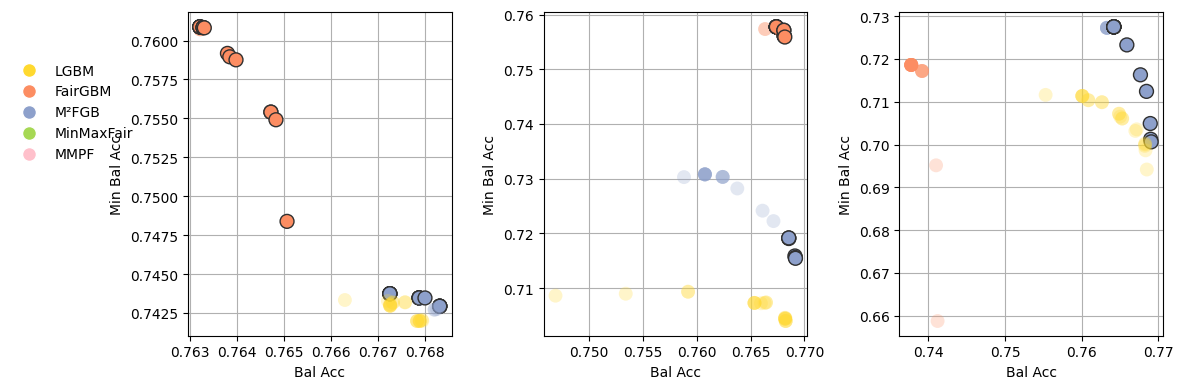

In [58]:
fig, axs = plt.subplots(nrows = 1, ncols = 3, figsize = (12, 4))


dataset_name = "acsincome"
methods = [
    "M2FGB_grad",
    #"M2FGB",
    "FairGBMClassifier",
    #"MinMaxFair",
    "LGBMClassifier",
    #"MinimaxPareto"
]
for ii, n_groups in enumerate([2, 4, 8]):
    results = []
    for model_name in methods:
        path = f"../results/experiment_{n_groups}_groups/{dataset_name}/{model_name}/"
        results.append(summary_experiment(dataset_name, model_name, path))

    results = pd.concat(results)

    dominated = []
    for i, row in results.iterrows():
        is_dominated = False
        for j, row2 in results.iterrows():
            if i == j:
                continue
            if row["bal_acc"] < row2["bal_acc"] and row["min_bal_acc"] < row2["min_bal_acc"]:
                is_dominated = True
                break
        dominated.append(is_dominated)
    results["dominated"] = dominated


    for model_name in methods:
        results_m = results[results.model == model_name]

        axs[ii].scatter(
            results_m.bal_acc,
            results_m.min_bal_acc,
            c = methods_color[model_name],
            s = 100,
            alpha = [0.25 if d else 1 for d in results_m.dominated],
            label = model_name,
            lw = [0 if d else 1 for d in results_m.dominated],
            zorder = 10,
            ec = ["#ffffff" if d else "#303030" for d in results_m.dominated]
        )

    
    #axs[ii].legend()
    axs[ii].set_xlabel("Bal Acc")
    axs[ii].set_ylabel("Min Bal Acc")
    axs[ii].grid(True)
    if ii == 0:
        axs[ii].legend(handles=handles, loc="lower left", bbox_to_anchor=(-0.7, 0.5), frameon=False)

plt.tight_layout()
plt.show()


In [67]:
dataset_name = "acsincome"
methods = [
    "M2FGB_grad",
    #"M2FGB",
    "FairGBMClassifier",
    #"MinMaxFair",
    "LGBMClassifier",
    #"MinimaxPareto"
]
n_groups = 8
results = []
for model_name in methods:
    path = f"../results/experiment_{n_groups}_groups/{dataset_name}/{model_name}/"
    results.append(summary_alpha(0.5, dataset_name, model_name, path))
results = pd.concat(results)
results

10
10
10


,alpha,dataset,model,bal_acc,min_bal_acc,time
10,0.5,acsincome,M2FGB_grad,0.764208,0.727528,188.913172
10,0.5,acsincome,FairGBMClassifier,0.737758,0.718631,77.717208
10,0.5,acsincome,LGBMClassifier,0.764890,0.707227,22.624612
